# ARGO Winter Project: RadRoads

## Coded in Python 3

## Objective
In a given area, identify:
1. Longest Road
2. Shortest Road
3. Straightest Road
4. Curviest Road

## Properties

`ox.graph_from_xxx` returns a [MultiDiGraph](https://networkx.github.io/documentation/networkx-1.10/reference/classes.multidigraph.html) (Directed graphs with self loops and parallel edges)

Edge attributes include:
- osmid: key in OSM
- name: road name
- highway: road type
- oneway (Boolean): one-way road (or not)
- length: road length (meters)

## NYC
- Entire city
- Zip code
- Neighborhood

In [14]:
import pandas as pd
import osmnx as ox
import networkx as nx

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Sandbox
## 1.1 Create a road segment dataframe

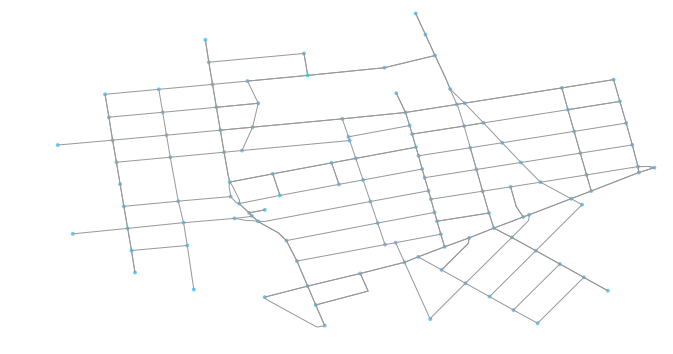

(<matplotlib.figure.Figure at 0x1171a9d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1171b78d0>)

In [2]:
# import a small area as sandbox
G = ox.graph_from_address('201 Moore St, Brooklyn, NY', distance=1000,
                          distance_type='network', network_type='drive')
ox.plot_graph(G)

In [5]:
# calculate basic stats of the graph
basic_stats = ox.basic_stats(G)
extended_stats = ox.extended_stats(G, bc=True)

basic_stats

{'circuity_avg': 1.0044244071925112,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 98.650210084860589,
 'edge_length_total': 28213.960084270129,
 'intersection_count': 120,
 'intersection_density_km': None,
 'k_avg': 4.688524590163935,
 'm': 286,
 'n': 122,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 104.53164531398525,
 'street_length_total': 19756.480964343213,
 'street_segments_count': 189,
 'streets_per_node_avg': 9.762295081967213,
 'streets_per_node_counts': {0: 0, 1: 14, 2: 0, 3: 153, 4: 177, 5: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.11475409836065574,
  2: 0.0,
  3: 1.2540983606557377,
  4: 1.4508196721311475,
  5: 0.01639344262295082}}

In [42]:
# check data structure for each edge (road segment)
segs = list(G.edges(data=True))
segs[0]

(42466686,
 42466688,
 {'highway': 'residential',
  'length': 42.743512009832763,
  'name': 'Bushwick Court',
  'oneway': False,
  'osmid': 5674905})

In [98]:
# pull out edge attributes as a dataframe
df = pd.DataFrame([[i[0], i[1], i[2]['highway'], i[2]['length'],
                    i[2]['name'], i[2]['oneway'], i[2]['osmid']] for i in segs],
                  columns=['node_a', 'node_b', 'type', 'length',
                           'name', 'oneway', 'osmid'])
df.head()

,node_a,node_b,type,length,name,oneway,osmid
0,42466686,42466688,residential,42.743512,Bushwick Court,False,5674905
1,42466686,42513670,secondary,42.380138,Bushwick Avenue,False,347717621
2,42466686,3539722830,secondary,12.522124,Bushwick Avenue,False,471943032
3,42466688,42466686,residential,42.743512,Bushwick Court,False,5674905
4,42467807,42467811,residential,79.154975,Graham Avenue,False,221753943


In [44]:
# check edge counts against basic stats of graph
len(df)

286

## 1.2 Combine road segments

This section is critical as it defines what we call a road. In this sandbox, a road is defined as connected segments that share a same road name.

### Issue 1: Multiple road names
Name column appears to be in list form in saome ways and needs to be converted to string type again before it can be grouped by. The problem appears to be due to some road names being coded as lists containing 2 roads, e.g., ['Forrest Street', 'Garden Street'].

In [99]:
df['name'] = df['name'].apply(lambda x: str(x))

### Issue 2: Starting and ending nodes
Current method removes all node information, a later version should identify and update the nodes for a road after the segments are combined and keep them in the dataframe.

In [110]:
# group by road names and calculate sums of lengths from all segments
# drop meaningless columns
df2 = df.groupby(by='name').sum().reset_index()
df2.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
df2.head()

,name,length
0,Boerum Street,786.530527
1,Bogart Street,1128.082398
2,Bushwick Avenue,2199.731455
3,Bushwick Court,85.487024
4,Bushwick Place,258.737162


In [121]:
# identify shortest roads
df2.sort_values('length', ascending=True).head()

,name,length
3,Bushwick Court,85.487024
36,Waterbury Street,157.800166
30,Seigel Court,158.570934
19,McKibbin Court,158.891626
39,"['Forrest Street', 'Garden Street']",196.109363


In [113]:
# identify longest roads
df2.sort_values('length', ascending=False).head()

,name,length
17,Johnson Avenue,2539.938848
8,Flushing Avenue,2260.559922
2,Bushwick Avenue,2199.731455
22,Meserole Street,1387.971589
25,Morgan Avenue,1374.179454


## 1.3 Validate

### Issue 3: Ground truth mismatch

Below are the distances measured on Google Map:

- Johnson Ave. (Brooklyn, NY):
1,484 m (4,870 ft.)

- Flushing Ave. (Brooklyn, NY):
1,118 m (3,669 ft.)

- Bushwick Ave. (Brooklyn, NY):
**PROBLEMATIC: some segments are separated directionally**

- Meserole St. (Brooklyn, NY):
877 m (2,877 ft.)

- Morgan Ave. (Brooklyn, NY):
790 m (2,594 ft.)

- Bushwick Court:
37 m

- Waterbury Street:
79 m

- Seigel Court:
79 m

### The guess is that two-way roads are doubled in distance for somehow. Does not affect the results for this small area for now but should come back and fix this later.

In [125]:
# validate segement counts
df3.sort_values('length').head(10)

,name,node_a,node_b,type,length,oneway,osmid
39,"['Forrest Street', 'Garden Street']",1,1,1,1,1,1
21,Melrose Street,1,1,1,1,1,1
16,Jefferson Street,1,1,1,1,1,1
29,Scholes Street,1,1,1,1,1,1
28,Rock Street,2,2,2,2,2,2
19,McKibbin Court,2,2,2,2,2,2
9,Forrest Street,2,2,2,2,2,2
30,Seigel Court,2,2,2,2,2,2
40,"['Montieth Street', 'Stanwix Street']",2,2,2,2,2,2
33,Vandervoort Place,2,2,2,2,2,2


In [122]:
# validate segement counts
df3 = df.groupby(by='name').count().reset_index()
df3.sort_values('length', ascending=False).head()

,name,node_a,node_b,type,length,oneway,osmid
2,Bushwick Avenue,31,31,31,31,31,31
8,Flushing Avenue,26,26,26,26,26,26
1,Bogart Street,26,26,26,26,26,26
17,Johnson Avenue,17,17,17,17,17,17
25,Morgan Avenue,17,17,17,17,17,17


### Fluching Ave. for example, only has 13 segments on the map but counts for 26 in the dataframe. Also, most roads start with at least 2 segments. Try to use duplicates to solve this. However, cases with odd numbers and separate lanes will have to be addressed differently.

**Consider:** divide by two if oneway == False

## 1.4 Construct a function

In [175]:
def howlong(place, ntype='drive'):
    """
    Find the shortest and longest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and length of the shortest road (length problem unsolved)
        2. name and length of the longest road (length problem unsolved)
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.graph_from_place(place, network_type='drive', which_result=1)
    except:
        G = ox.graph_from_place(place, network_type='drive', which_result=2)
    
    # convert road segments as df
    segs = list(G.edges(data=True))

    df = pd.DataFrame([[i[0], i[1], i[2]['highway'], i[2]['length'],
                        i[2]['name'], i[2]['oneway'], i[2]['osmid']] for i in segs if 'name' in i[2]],
                      columns=['node_a', 'node_b', 'type', 'length',
                               'name', 'oneway', 'osmid'])
    df['name'] = df['name'].apply(lambda x: str(x))

    # combine road segments
    df2 = df.groupby(by='name').sum().reset_index()
    df2.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
    
    # calculate shortest and longest roads
    short = df2.sort_values('length', ascending=True).head(1).iloc[0]
    long = df2.sort_values('length', ascending=False).head(1).iloc[0]

    # output
    print('Shortest road: {:s} ({:.2f} meters)'.format(short['name'], short['length']))
    print('Longest road: {:s} ({:.2f} meters)'.format(long['name'], long['length']))

    ox.plot_graph(G);

### Issue 4: Missing road name

This function soon ran into a problem: some edge does not have name and throws back a key error. This is handled by only extracting edges with a 'name' key in the attributes.

Shortest road: Baruch Place (13.80 meters)
Longest road: Broadway (33808.79 meters)


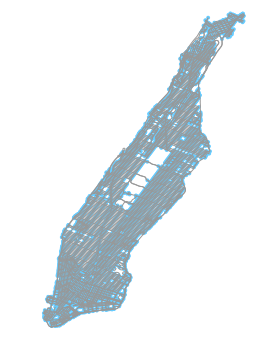

In [176]:
howlong('Manhattan, NY')

Shortest road: ['Seaview Avenue', 'Gateway Drive'] (13.39 meters)
Longest road: Belt Parkway (52746.24 meters)


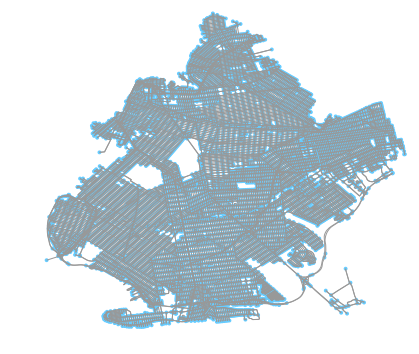

In [178]:
howlong('Brooklyn, NY')

Shortest road: ['環中東路一段', '環中東路二段'] (10.21 meters)
Longest road: 東西向快速公路 快官霧峰線 (74492.75 meters)


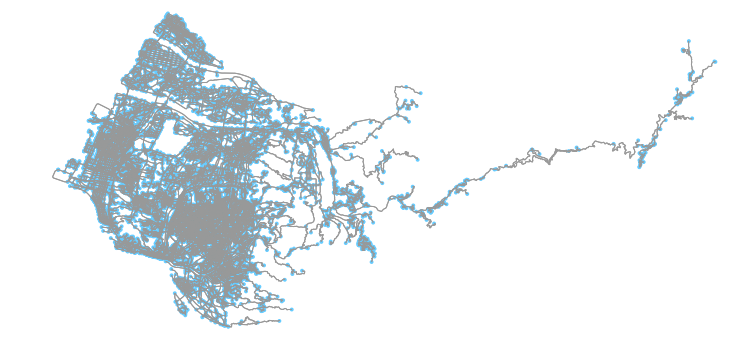

In [177]:
howlong('Taichung City, Taiwan')

### Issue 5: Outliers

1. Longest roads may end up being highways that does not really make sense in some urban problem context.
2. Shortest roads may end up being a short drive way, court, or even a tiny segment between two lanes of a crossing road.

**Consider:** subsetting road types and setting a boundary for reasonable road length

## 1.5 Visualize
Color the identified roads back onto the map:
1. Approach 1: rebuild a graph based on the dataframe. This requires we pull out node attributes as well and merge it with edge dataframe.
2. Approach 2: pass osmid back to the original graph and color it accordingly.

# Notebook ends here

1. Direction
2. Width
3. Angle

In [69]:
# lens = list(nx.get_edge_attributes(G2, 'length').values())
# max(lens)

305.40620395441033

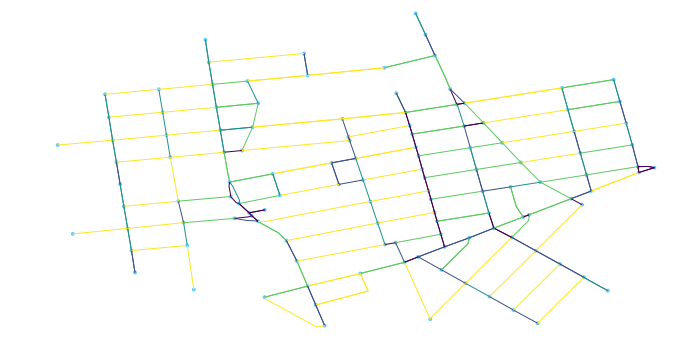

(<matplotlib.figure.Figure at 0x11865e0b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118758898>)

In [123]:
# ec = ox.get_edge_colors_by_attr(G, attr='length')
# ox.plot_graph(G, edge_color=ec)

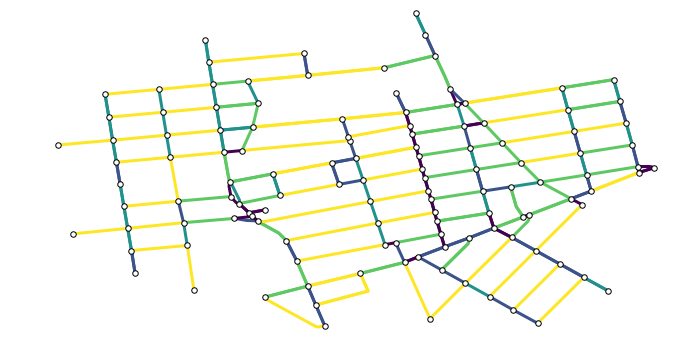

In [80]:
# fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=30, 
#                             node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:
# ox.graph_from_place('Manhattan, NY', network_type='drive', which_result=2)
# ox.plot_graph(ox.graph_from_place('Taipei, Taiwan', which_result=2))

# city = ox.gdf_from_place('Berkeley, CA')
# ox.plot_shape(ox.project_gdf(city))